# Task 1: Big Cats
### Alina, Lisa, Ömer and Nikolai

## Import Data

In [14]:
import os

import cv2 as cv
import imgaug.augmenters as iaa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.transform import resize
from skimage.feature import hog

In [15]:
RANDOM_STATE=50

In [16]:
data_path = os.path.join("..", "Data-PR-As2", "BigCats")

In [17]:
class_paths = os.listdir(data_path)
imgs = []
labels = []
for class_ in class_paths:
    if class_ != '.DS_Store':
        path = os.path.join(data_path, class_)
        imgs_of_class = os.listdir(path)
        n_imgs_of_class = len(imgs_of_class)
        for x in imgs_of_class:
            if x != '.DS_Store':
                imgs.append(os.path.join(path, x))
            else:
                n_imgs_of_class -= 1

        # imgs += [os.path.join(path, x) for x in imgs_of_class]
        # labels += [class_] * len(imgs_of_class)
        labels += [class_] * n_imgs_of_class

## Data Analysis

In [18]:
print("# observations:", len(labels))

# observations: 170


In [19]:
classes = list(np.unique(labels))
n_classes = len(classes)
print("There are", n_classes, "classes:", classes)

There are 5 classes: ['Cheetah', 'Jaguar', 'Leopard', 'Lion', 'Tiger']


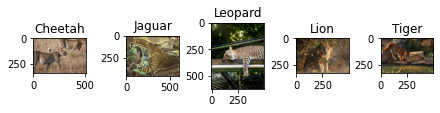

In [20]:
# Visualise one data sample per class
fig, axs = plt.subplots(1, n_classes, constrained_layout=True)
fig.patch.set_facecolor('white')
axs = axs.flatten()

for i, class_ in enumerate(classes):
    ob_idx = labels.index(class_)
    with Image.open(imgs[ob_idx]) as img:
        axs[i].imshow(img)
        axs[i].title.set_text(class_)
plt.show()

In [21]:
def plot_class_freq(y):
    ax = y.apply(pd.value_counts).plot(kind='bar', legend=False)
    if matplotlib.__version__[:3] != "3.3":
        ax.bar_label(ax.containers[0])
    else:
        print("Warning using old version of matplotlib!")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.show()

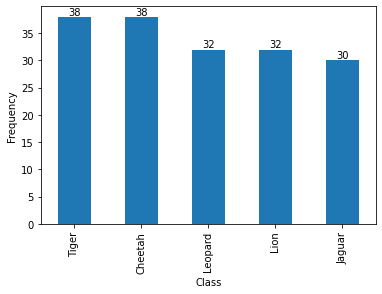

In [22]:
# Check for data imbalance
plot_class_freq(pd.DataFrame(labels))

## Feature Extraction

In [23]:
def process_img(img):
    #img = cv.GaussianBlur(img,(13,13),0) # did not help
    #_, img = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return img

def extract_with_sift(data, num_des=247, display_idxs={}):
    sift = cv.SIFT_create()
    features = np.array([])
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.PerspectiveTransform(scale=(0.05, 0.15))
    ])
    
    for i, x in enumerate(data):
        if '.DS_Store' not in x:
            img = cv.imread(x)
            bw_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            bw_img = process_img(bw_img)
            
            aug_img = aug_seq(images=[bw_img])

            kp, des = sift.detectAndCompute(bw_img, None)
            kp_aug, des_aug = sift.detectAndCompute(aug_img[0], None)

            #selection = np.random.choice(des.shape[0], num_des) # Don't think this is a good idea
            #des = des[selection]
            features = np.vstack((des, features)) if features.size else des
            features = np.vstack((des_aug, features)) if features.size else des_aug
            
        if i in display_idxs:
            #kp = np.array(kp)[selection]
            img_sift = cv.drawKeypoints(bw_img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()

            img_sift = cv.drawKeypoints(aug_img[0], kp_aug, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.imshow(img_sift)
            plt.show()
    
    return features

In [24]:
def extract_with_hog(data, aug):
    features = np.array([])
    aug_seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.PiecewiseAffine(scale=(0.01, 0.05)),
        iaa.PerspectiveTransform(scale=(0.05, 0.15))
    ])
    for i, x in enumerate(data):
        if '.DS_Store' not in x:
            img = cv.imread(x)
            blur_img = cv.blur(img,(5,5))
            bw_img = cv.cvtColor(blur_img, cv.COLOR_BGR2GRAY)
            
            if aug:
                aug_img = aug_seq(images=bw_img)
                resized_aug_img = resize(np.asarray(aug_img), (128, 64))
                feat_aug = hog(resized_aug_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
                features = np.vstack((feat_aug, features)) if features.size else feat_aug
            else:
                resized_img = resize(bw_img, (128,64))
                feat = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
                features = np.vstack((feat, features),) if features.size else feat
    return features

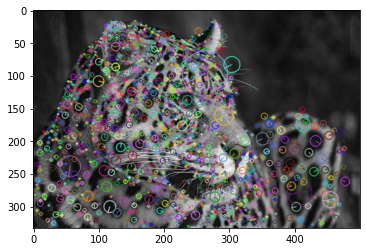

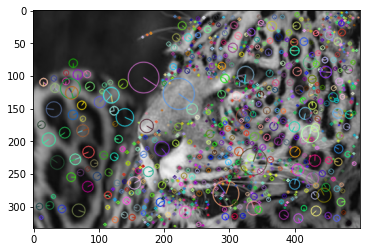

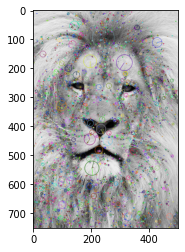

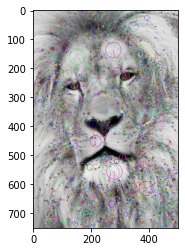

In [25]:
img_train, img_test, label_train, label_test = train_test_split(imgs, labels, test_size=0.2, random_state=RANDOM_STATE)

all_features = extract_with_sift(img_train, display_idxs={0, 5})
hog_features = extract_with_hog(img_train, False)

In [26]:
# This takes a while
N_CLUSTERS=100
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
kmeans.fit(all_features)

KMeans(n_clusters=100, random_state=50)

In [27]:
def build_histogram(kmeans, data):
    pred = kmeans.predict(data)
    hist, _ = np.histogram(pred, bins=N_CLUSTERS)
    hist_norm = [float(i)/sum(hist) for i in hist]
    return hist_norm

# Reflects importance of BOVW features in the image histograms
# See https://en.wikipedia.org/wiki/Tf%E2%80%93idf for more information
def tf_idf_histogram(train_hists, test_hists):
    hists = np.concatenate((np.array(train_hists), np.array(test_hists)), axis=0)
    tf_idf_hists = np.zeros(hists.shape)
    N = hists.shape[0] # total number of images
    n_i = np.sum(hists > 0, axis=0) # number of images where the word w appears (per word)
    for hist_id in range(N):
        n_words_i = np.sum(hists[hist_id]) # number of words in the image
        for word_id in range(len(hists[hist_id])):
            n_wi = hists[hist_id, word_id] # count of word w in image i
            tf_idf_hists[hist_id, word_id] = n_wi / n_words_i * np.log(N/n_i[word_id])
    return tf_idf_hists[:len(train_hists)], tf_idf_hists[-len(test_hists):]

def run_model(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels)
    yhat = model.predict(test_data)
    accuracy = accuracy_score(test_labels, yhat)
    f_1 = f1_score(test_labels, yhat, average='micro')
    conf_mat = confusion_matrix(test_labels, yhat)
    # roc_auc = roc_auc_score(test_labels, yhat)
    # return [accuracy, f_1, conf_mat, roc_auc], model
    return accuracy, f_1, conf_mat

Cluster descriptors

In [42]:
label_train_hog = label_train[:]
kmeans_train_features_sift = []
kmeans_train_features_hog = []
for img_id in range(len(img_train)):
    if img_train[img_id] is not None:
        d = [img_train[img_id]]
        if '.DS_Store' not in d[0]:
            kmeans_train_features_sift.append(build_histogram(kmeans, extract_with_sift(d)))
            kmeans_train_features_hog.append(extract_with_hog(d, False))
            kmeans_train_features_hog.append(extract_with_hog(d, True))
            if img_id == 0:
                label_train_hog.insert(img_id, label_train[img_id])
            else:
                label_train_hog.insert((img_id * 2 + 1), label_train[img_id])

            
    else:
        label_train.pop(img_id)

kmeans_test_features_sift = []  
kmeans_test_features_hog = []     
for img_id in range(len(img_test)):
    if img_test[img_id] is not None:
        d = [img_test[img_id]]
        if '.DS_Store' not in d[0]:
            kmeans_test_features_sift.append(build_histogram(kmeans, extract_with_sift(d)))
            kmeans_test_features_hog.append(extract_with_hog(d, False))
    else:
        label_test.pop(img_id)

kmeans_train_features_sift, kmeans_test_features_sift = tf_idf_histogram(kmeans_train_features_sift, kmeans_test_features_sift)
kmeans_train_features_hog, kmeans_test_features_hog = tf_idf_histogram(kmeans_train_features_hog, kmeans_test_features_hog)

print(np.asarray(kmeans_train_features_hog).shape, np.asarray(kmeans_train_features_sift).shape, len(label_train_hog))
score_sift = run_model(RandomForestClassifier(), kmeans_train_features_sift, label_train, kmeans_test_features_sift, label_test)
print("Sift feature results:")
print("Accuracy: {}, F1: {}, confusion matrix: {}".format(score_sift[0], score_sift[1], score_sift[2]))
score_hog = run_model(RandomForestClassifier(), kmeans_train_features_hog, label_train_hog, kmeans_test_features_hog, label_test)
print("HOG feature results:")
print("Accuracy: {}, F1: {}, confusion matrix: {}".format(score_hog[0], score_hog[1], score_hog[2]))

(272, 3780) (136, 100) 272
Sift feature results:
Accuracy: 0.47058823529411764, F1: 0.47058823529411764, confusion matrix: [[4 0 3 0 0]
 [1 3 2 1 0]
 [2 1 3 0 0]
 [1 0 0 2 6]
 [0 0 0 1 4]]
HOG feature results:
Accuracy: 0.29411764705882354, F1: 0.29411764705882354, confusion matrix: [[5 2 0 0 0]
 [1 4 1 0 1]
 [3 1 1 0 1]
 [2 0 2 0 5]
 [3 0 2 0 0]]
(272, 3780) (136, 100) 272
Sift feature results:
Accuracy: 0.5, F1: 0.5, confusion matrix: [[3 2 2 0 0]
 [1 2 3 1 0]
 [1 1 4 0 0]
 [0 0 0 4 5]
 [0 0 0 1 4]]
HOG feature results:
Accuracy: 0.35294117647058826, F1: 0.35294117647058826, confusion matrix: [[6 0 1 0 0]
 [3 1 1 1 1]
 [3 1 1 0 1]
 [4 1 0 1 3]
 [2 0 0 0 3]]


KeyboardInterrupt: 